## **Final Project ISC 4242: Fetal Health Classification**
#### **Sidney Christensen**
#### **4/4/24**

![title](fetal_image.png)

Low-resource regions suffer from both maternal and child mortality in instances where this could have been prevented. Cardiotocograms are a promising solution that is cost-accessible to these areas, and our goal is to build predictive models that can take data obtained by the cardiotocogram during the third trimester/during labor and classify the fetal health as normal (0), suspect (1), or pathological (2) as accurately as a doctor would. If we are able to find correctly classify a fetus as suspect or pathological, doctors can take the next steps in exploring the conditions of the mother and fetus accordingly, thus preventing mortality for both mother and fetus.

The following code is split into four sections, where each section holds the code for each of the four 
training models: Support Vector Machine, Extreme Gradient Boosting, Random Forest, and two Neural Networks

#### Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_wine, make_classification
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

#### Read in CSV

In [2]:
data = pd.read_csv("C:/Users/sidne/Downloads/fetal_health.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline_value                                          2126 non-null   int64  
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   int64  
 8   mean_value_of_short_term_variability  

#### Data Visualizations

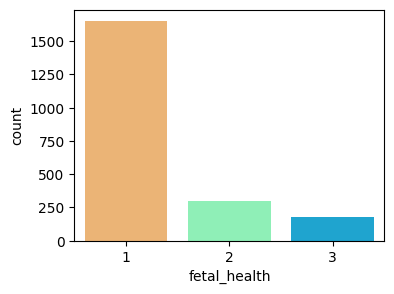

In [4]:
plt.figure(figsize=(4, 3))
sns.countplot(data = data, x = "fetal_health", palette = 'rainbow_r')
plt.show()

We can see the data is very imbalanced. It was recommended to use SMOTE technique to rebalance the data because 
unlike simple oversampling techniques that duplicate existing minority class samples, SMOTE generates synthetic 
samples by interpolating between existing minority class samples. This helps prevent overfitting and preserves 
the underlying distribution of the minority class, leading to better generalization performance.

<Axes: >

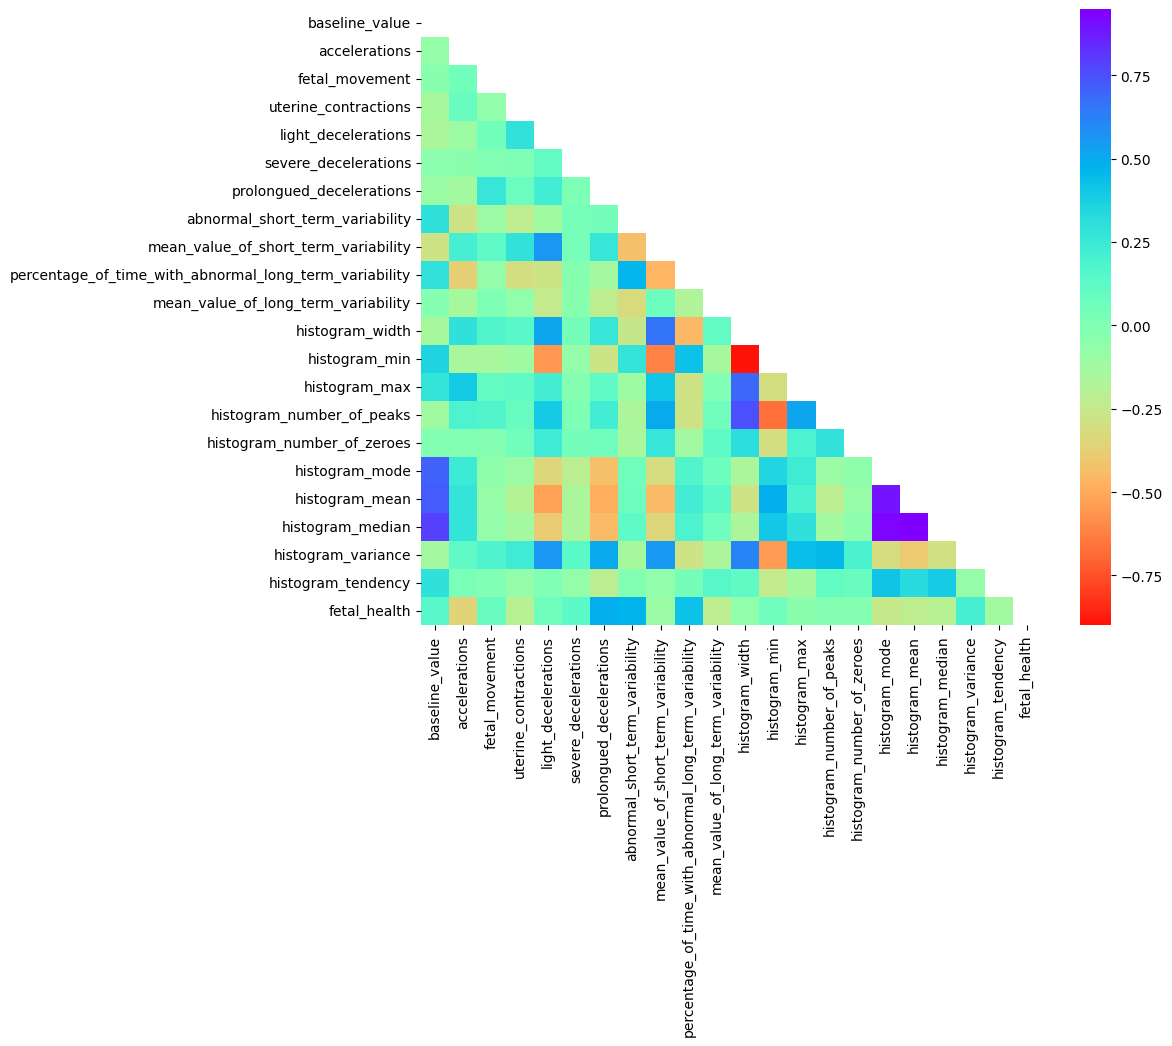

In [5]:
corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10,8)) 
sns.heatmap(corr_matrix, annot = False, mask = mask, cmap = 'rainbow_r', center = 0)

#### Checking for missing values

In [6]:
missing_values = data.isnull().sum()
if missing_values.sum() == 0:
    print("No missing values.")
else:
    print("Missing values:\n", missing_values)

No missing values.


#### Preprocessing

In [7]:
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

class_mapping = {1: 0, 2: 1, 3: 2} 
y_mapped = [class_mapping[cls] for cls in y] 
print(f'y: {np.unique(y)}')
print(f'y_mapped: {np.unique(y_mapped)}')

X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

y: [1 2 3]
y_mapped: [0 1 2]


Both Scikit-Learn and PyTorch expect class labels to start from 0, and thus we use mapping to make class labels 0, 1, 2 instead of 1, 2, 3. We also split the data into testing and training sets at this point.

#### Feature Selection: Feature rank is computed using ANOVA F-test

In [8]:
num_features_to_keep = 10 
column_names = X.columns

selector = SelectKBest(score_func=f_classif, k=num_features_to_keep)

X_train_selected = selector.fit_transform(X_train, y_train)
selected_feature_indices = selector.get_support(indices=True)
anova_scores = selector.scores_[selected_feature_indices]
selected_feature_names = np.array(column_names)[selected_feature_indices]

print("ANOVA Test Scores:", anova_scores)
print("\nTop 10 features:", selected_feature_names)

ANOVA Test Scores: [118.44894345 158.12070038 418.58836455 278.59481102  90.29393012
 256.43008258 229.56205293 255.90393249 209.05399134 128.82954791]

Top 10 features: ['baseline_value' 'accelerations' 'prolongued_decelerations'
 'abnormal_short_term_variability' 'mean_value_of_short_term_variability'
 'percentage_of_time_with_abnormal_long_term_variability' 'histogram_mode'
 'histogram_mean' 'histogram_median' 'histogram_variance']


In [9]:
X_train = X_train[['baseline_value','accelerations','prolongued_decelerations',
                             'abnormal_short_term_variability','mean_value_of_short_term_variability',
                             'percentage_of_time_with_abnormal_long_term_variability','histogram_mode',
                             'histogram_mean','histogram_median','histogram_variance']]

X_test = X_test[['baseline_value', 'accelerations', 'prolongued_decelerations',
                          'abnormal_short_term_variability', 'mean_value_of_short_term_variability',
                          'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mode',
                          'histogram_mean', 'histogram_median', 'histogram_variance']]

smote = SMOTE(random_state=42)
scaler = StandardScaler()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print(f'# observations in training after SMOTE: {len(X_train_resampled)}')

# observations in training after SMOTE: 3966


### Preprocessing Pipeline:

#### SVM: Feature Selection, SMOTE, Normalization
#### XGB: Feature Selection, SMOTE
#### Random Forest: Feature Selection, SMOTE, Normalization
#### Neural Network #1: SMOTE, Normalization
#### Neural Network #2: SMOTE, Normalization

#### Before beginning the model building process, it is important to note that we not only want an accurate model, we also want a model that can most accurately classify classes (1) and (2), which are "suspect" and "pathological" respectively. These two classes indicate further medical intervention is necessary, thus indicating the model is successful in identifying observations where fetal health must be more thoroughly examined and addressed. As discussed in the project report, Recall and F1-scores are the most valued metrics to consider

### Support Vector Classifier

The grid search wil take about 5-10 minutes.

In [10]:
param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 0.01, 0.001],
    'svm__degree': [2],
}

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),  
    ('svm', SVC()),  
])

In [11]:
grid_search = GridSearchCV(pipeline, param_grid_svm, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'svm__C': 10, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


In [12]:
SVM_model = SVC(C = 10, gamma = 0.1, kernel = 'rbf')

SVM_model.fit(X_train_resampled_scaled, y_train_resampled) 
y_pred_SVM = SVM_model.predict(X_test_scaled) 

report = classification_report(y_test, y_pred_SVM)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       333
           1       0.65      0.92      0.76        64
           2       0.90      0.93      0.92        29

    accuracy                           0.91       426
   macro avg       0.85      0.92      0.87       426
weighted avg       0.93      0.91      0.92       426



The support vector machine displays a solid recall for all three classes, all being at least .91. The model has a strong accuracy of 91%, but a potential drawback is the poor f1-score for the second class. 

### Extreme Gradient Boosting Algorithm

The Extreme Gradient Boosting algorithm is another tree-based alogorithm in which new models are added to the ensemble. These added models correct the mistakes made by the models already existing, which are usually very shallow decision trees (base learners). The grid search will take about 5-10 minutes

In [13]:
pipeline_XGB = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
])

param_grid = {
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__n_estimators': [100, 200, 300]
}

In [14]:
grid_search = GridSearchCV(pipeline_XGB, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
{'xgb__colsample_bytree': 0.9, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__subsample': 0.9}


In [15]:
XGB_model = XGBClassifier(
    colsample_bytree = 0.9,
    learning_rate = 0.1,
    max_depth = 7,
    n_estimators = 200,
    subsample = 0.9
) 

XGB_model.fit(X_train_resampled, y_train_resampled)
y_pred_XGB = XGB_model.predict(X_test)

report = classification_report(y_test, y_pred_XGB)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       333
           1       0.83      0.86      0.85        64
           2       0.88      1.00      0.94        29

    accuracy                           0.95       426
   macro avg       0.90      0.94      0.92       426
weighted avg       0.95      0.95      0.95       426



#### The XGB model has much better precision and F1-scores for class 1 which the SVC lacked. So far, this appears to be the best model. This model exhibits a strong recall for all three classes, especially the the "pathological" class (2). This is the most favorable model so far.

### Random Forest

Random forest classification is an ensemble technique that involves creating a plethora of decision trees each using a 
random subset of features (feature bagging). It collects the class vote from each tree to determine the final prediction. 
As previously noted, random forests are a tree-based algorithm and thus not sensitive to feature scale, so scaling is not necessary. However, class 
imbalance will be addressed by SMOTE as it is in the other three models. The grid-search will take about 5-10 minutes.

In [16]:
param_grid_RF = { 
    'rf__n_estimators': [100,200,300],
    'rf__max_features': [None, 'sqrt', 'log2'],
    'rf__max_depth' : [6,8,12],
    'rf__criterion' :['gini', 'entropy']
}

pipeline_RF = ImbPipeline([
    ('smote', SMOTE()),  
    ('rf', RandomForestClassifier())  
])

In [17]:
grid_search = GridSearchCV(pipeline_RF, param_grid=param_grid_RF)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'rf__criterion': 'entropy', 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__n_estimators': 300}


*Let me note here that this was the only model during training that kept changing the best parameters, but after
seeing how all suggested parameter combinations perform, the one utilized below was indeed the best set of parameters.
If the grid search above does not return the parameters below, ignore them.*

In [22]:
RF_model = RandomForestClassifier(criterion = 'entropy', 
                                  max_depth = 12,
                                  max_features = 'sqrt',
                                  n_estimators = 300,
                                 random_state = 40)

RF_model.fit(X_train_resampled, y_train_resampled) 
y_pred_RF = RF_model.predict(X_test) 

report = classification_report(y_test, y_pred_RF)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       333
           1       0.81      0.91      0.85        64
           2       0.94      1.00      0.97        29

    accuracy                           0.95       426
   macro avg       0.91      0.95      0.93       426
weighted avg       0.95      0.95      0.95       426



Again, looking at recall, model seems to be the highest performing in our most important classes, 1 & 2 with recalls of .91 and 1.00 respectively. Since this model has a higher recall than the XGB for class 2 and the same recall of 1.00, the Random Forest model is in the lead.

### Neural Networks (Classification)

Two Neural Networks have been built. As stated previously, we will omit the feature selection part of preprocessing as the neural networks performed better with all features present. Above each NN is a description of each and the process used to build them. Let it be noted that building Neural Networks can be a delicate process the more complex they get. I first chose the number of layers. I then initialized the weights, followed by the loss function and optimization algorithm before tuning other parameters such as batch size, learning rate, etc. 

In [19]:
data = pd.read_csv("C:/Users/sidne/Downloads/fetal_health.csv")

X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

class_mapping = {1: 0, 2: 1, 3: 2} 
y_mapped = [class_mapping[cls] for cls in y] 
print(f'y: {np.unique(y)}')
print(f'y_mapped: {np.unique(y_mapped)}')

X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

X_test_scaled = scaler.transform(X_test)

y: [1 2 3]
y_mapped: [0 1 2]


#### This neural network consists of the input layer, one hidden layer, and output layer. ReLU() is the chosen activation function. He/Kaiming initialization is used as it works well with ReLU() and generalizes well. Softmax is used on the output layer as it pairs well with the cross entropy loss function. As for the parameters, the neural network performed better every epoch until about the 10th epoch, and thus there will be ten epoches. Additionally, the NN performed better with a batch size of 64 than with a batch size of 32. SGD is our optimization algorithm. Since SGD can often get stuck in saddle points, momentum was introduced and performed best with a rate of 0.9

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

torch.manual_seed(42)

class MultiClassNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MultiClassNN, self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size2, num_classes)
        
        nn.init.kaiming_normal_(self.linear1.weight)
        nn.init.kaiming_normal_(self.linear2.weight)
        nn.init.kaiming_normal_(self.linear3.weight)
    
    def forward(self, x):
        
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = F.softmax(x, dim=1) 
        
        return x
    
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        current = batch * len(X)
        print(f"    [{current:>5d}/{size:>5d}]  Loss: {loss_value:.6f}")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:.6f} \n")

X_train_tensor = torch.tensor(X_train_resampled_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_size = X_train.shape[1]
hidden_size1 = 50
hidden_size2 = 25
num_classes = 3
num_epochs = 10
batch_size = 64

model = MultiClassNN(input_size, hidden_size1, hidden_size2, num_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Training finished!\n")

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy:.4f}')
    
print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

Epoch 1/10
-------------------------------
    [    0/ 3966]  Loss: 1.186278
    [   64/ 3966]  Loss: 1.146247
    [  128/ 3966]  Loss: 1.117517
    [  192/ 3966]  Loss: 1.055392
    [  256/ 3966]  Loss: 1.027312
    [  320/ 3966]  Loss: 1.044396
    [  384/ 3966]  Loss: 0.834082
    [  448/ 3966]  Loss: 0.849299
    [  512/ 3966]  Loss: 0.882100
    [  576/ 3966]  Loss: 0.823525
    [  640/ 3966]  Loss: 0.845998
    [  704/ 3966]  Loss: 0.763562
    [  768/ 3966]  Loss: 0.789205
    [  832/ 3966]  Loss: 0.810187
    [  896/ 3966]  Loss: 0.779035
    [  960/ 3966]  Loss: 0.871563
    [ 1024/ 3966]  Loss: 0.837418
    [ 1088/ 3966]  Loss: 0.689877
    [ 1152/ 3966]  Loss: 0.802291
    [ 1216/ 3966]  Loss: 0.777788
    [ 1280/ 3966]  Loss: 0.690143
    [ 1344/ 3966]  Loss: 0.707079
    [ 1408/ 3966]  Loss: 0.753621
    [ 1472/ 3966]  Loss: 0.711364
    [ 1536/ 3966]  Loss: 0.718071
    [ 1600/ 3966]  Loss: 0.670783
    [ 1664/ 3966]  Loss: 0.759244
    [ 1728/ 3966]  Loss: 0.653495
    [

Comparing this neural network to our best model at present (Random Forest), this NN has significantly weaker recall and F1-scores. 
Even though the classes have been balanced using SMOTE, the neural network is not as successful in correctly classifying them. Let us explore another architecture.

#### This next neural network uses He/Kaiming initialization and ReLU() activation as well. In this NN however, I instead wanted to experiment with the Adam optimizer. The inital learning rate of the Adam algorithm is .01. Additionally, this NN utilizes three hidden layers instad of one. This algorithm is often a good choice due to its adaptive learning rate and strong momentum, which we manually had to incorporate with the SGD algorithm used above. We use a batch size of 32 and 10 epoches. Here, Hinge loss is our loss function and softmax activation is consequently not used on the output layer since hinge loss is not designed to work with probabilities generated by softmax. Lastly, we use a learning rate scheduler to fine-tune the learning rate during training.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)

class MultiClassNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes):
        super(MultiClassNN, self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(hidden_size4, num_classes)
        
        nn.init.kaiming_normal_(self.linear1.weight)
        nn.init.kaiming_normal_(self.linear2.weight)
        nn.init.kaiming_normal_(self.linear3.weight)
        nn.init.kaiming_normal_(self.linear4.weight)
        nn.init.kaiming_normal_(self.linear5.weight)
    
    def forward(self, x):
        
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.relu4(x)
        x = self.linear5(x)

        return x
    
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        loss_value = loss.item()
        current = batch * len(X)
        print(f"    [{current:>5d}/{size:>5d}]  Loss: {loss_value:.6f}")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:.6f} \n")
    
X_train_tensor = torch.tensor(X_train_resampled_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]
hidden_size1, hidden_size2, hidden_size3, hidden_size4 = 50, 35, 20, 3
num_classes = 3
num_epochs = 10
batch_size = 32

model = MultiClassNN(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, num_classes)
loss_fn = nn.MultiMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    scheduler.step()

print("Training finished!\n")

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy:.4f}')
    
print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

Epoch 1/10
-------------------------------
    [    0/ 3966]  Loss: 0.904424
    [   64/ 3966]  Loss: 0.603676
    [  128/ 3966]  Loss: 0.537675
    [  192/ 3966]  Loss: 0.600468
    [  256/ 3966]  Loss: 0.596991
    [  320/ 3966]  Loss: 0.611007
    [  384/ 3966]  Loss: 0.587295
    [  448/ 3966]  Loss: 0.594085
    [  512/ 3966]  Loss: 0.485833
    [  576/ 3966]  Loss: 0.503291
    [  640/ 3966]  Loss: 0.511104
    [  704/ 3966]  Loss: 0.436257
    [  768/ 3966]  Loss: 0.486510
    [  832/ 3966]  Loss: 0.583207
    [  896/ 3966]  Loss: 0.502225
    [  960/ 3966]  Loss: 0.500672
    [ 1024/ 3966]  Loss: 0.486628
    [ 1088/ 3966]  Loss: 0.406797
    [ 1152/ 3966]  Loss: 0.465001
    [ 1216/ 3966]  Loss: 0.434195
    [ 1280/ 3966]  Loss: 0.431375
    [ 1344/ 3966]  Loss: 0.450735
    [ 1408/ 3966]  Loss: 0.440427
    [ 1472/ 3966]  Loss: 0.356045
    [ 1536/ 3966]  Loss: 0.390800
    [ 1600/ 3966]  Loss: 0.367650
    [ 1664/ 3966]  Loss: 0.347973
    [ 1728/ 3966]  Loss: 0.334438
    [

While the accuracy of this NN reached about 90%, we must again look at the specific class recalls and f1-score. This NN was not the strongest in prediciting classes 1 an 2 as it was in predicting class 0. This Neural Network however does perform better than the first one in terms of both accuracy and predicting the two more crucial classes. While the Random Forest still beats both neural networks, it was enjoyable to build them, experiment with different parameters, and learn the nuanced and safe way to adjust different elements of the models as I went. 